# Fake News Detection

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Read Datasets

In [82]:
fake = pd.read_csv("Fake.csv")
real = pd.read_csv("True.csv")

In [83]:
fake.shape

(23481, 4)

In [84]:
real.shape

(21417, 4)

# Data cleaning and preparation

In [85]:
# Add flag to track fake and real

fake['target'] = 'fake'
real['target'] = 'real'

In [86]:
# Concatenate dataframes
data = pd.concat([fake,real]).reset_index(drop = True)

data.shape

(44898, 5)

In [87]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop = True)

In [88]:
data.head()

,title,text,subject,date,target
0,Mexico foreign minister heads to U.S. to meet ...,MEXICO CITY (Reuters) - Mexico s Foreign Minis...,worldnews,"September 11, 2017",real
1,Obama’s Legacy: Washington is Lying About ISIS...,21st Century Wire says ISIS inspired. Assad s ...,US_News,"October 21, 2016",fake
2,BREAKING NEWS: NYPD Cracking Down On Anti-Trum...,Antifa terrorists have gathered in major citie...,politics,"May 1, 2017",fake
3,DEAR RNC: An Everyday American Writes A Letter...,This letter was sent to 100% FED Up! by an ano...,Government News,"Mar 2, 2016",fake
4,Corporate America (And The Walking Dead) Wins...,Today we found out who s REALLY in control of ...,News,"March 28, 2016",fake


In [89]:
# Removing the date

data.drop(['date'],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Mexico foreign minister heads to U.S. to meet ...,MEXICO CITY (Reuters) - Mexico s Foreign Minis...,worldnews,real
1,Obama’s Legacy: Washington is Lying About ISIS...,21st Century Wire says ISIS inspired. Assad s ...,US_News,fake
2,BREAKING NEWS: NYPD Cracking Down On Anti-Trum...,Antifa terrorists have gathered in major citie...,politics,fake
3,DEAR RNC: An Everyday American Writes A Letter...,This letter was sent to 100% FED Up! by an ano...,Government News,fake
4,Corporate America (And The Walking Dead) Wins...,Today we found out who s REALLY in control of ...,News,fake


In [90]:
# Removing the title
data.drop(['title'],axis=1,inplace=True)
data.head()

,text,subject,target
0,MEXICO CITY (Reuters) - Mexico s Foreign Minis...,worldnews,real
1,21st Century Wire says ISIS inspired. Assad s ...,US_News,fake
2,Antifa terrorists have gathered in major citie...,politics,fake
3,This letter was sent to 100% FED Up! by an ano...,Government News,fake
4,Today we found out who s REALLY in control of ...,News,fake


In [91]:
# Convert to lowercase
data['text'] = data['text'].apply(lambda x: x.lower())

data.head()

,text,subject,target
0,mexico city (reuters) - mexico s foreign minis...,worldnews,real
1,21st century wire says isis inspired. assad s ...,US_News,fake
2,antifa terrorists have gathered in major citie...,politics,fake
3,this letter was sent to 100% fed up! by an ano...,Government News,fake
4,today we found out who s really in control of ...,News,fake


In [92]:
# Remove punctuation
import nltk
import re
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
import string

def create_features_from_df(df):
    def punctuation_removal(text):
        all_list = [char for char in text if char not in string.punctuation]
        clean_str = ''.join(all_list)
        return clean_str
    
    def clean_text(text):
      txt = re.sub("[( ' )( ')(' )]", ' ', text)
      txt=re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w +:\ / \ / \S +)", " ", txt)
      return txt.lower()
    
    def remove_stopwords():
      nltk.download('stopwords')
      from nltk.corpus import stopwords
      stop = stopwords.words('english')
      data['text'] = data['text'].apply(lambda x:' '.join([word for word in x.split() if word not in (stop)]))

    def deEmojify(text):
      regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags = re.UNICODE)
      return regrex_pattern.sub(r'', text)

    df['cleaned_tweets'] = df['tweets'].apply(lambda x: punctuation_removal(str(x)))
    df['cleaned_tweets'] = df['cleaned_tweets'].apply(lambda x: clean_text(str(x)))
    df['cleaned_tweets'] = df['cleaned_tweets'].apply(lambda x: deEmojify(str(x)))
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Priyanshu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [93]:
data.head()

,text,subject,target
0,mexico city (reuters) - mexico s foreign minis...,worldnews,real
1,21st century wire says isis inspired. assad s ...,US_News,fake
2,antifa terrorists have gathered in major citie...,politics,fake
3,this letter was sent to 100% fed up! by an ano...,Government News,fake
4,today we found out who s really in control of ...,News,fake


In [94]:
data.head()

,text,subject,target
0,mexico city (reuters) - mexico s foreign minis...,worldnews,real
1,21st century wire says isis inspired. assad s ...,US_News,fake
2,antifa terrorists have gathered in major citie...,politics,fake
3,this letter was sent to 100% fed up! by an ano...,Government News,fake
4,today we found out who s really in control of ...,News,fake


subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


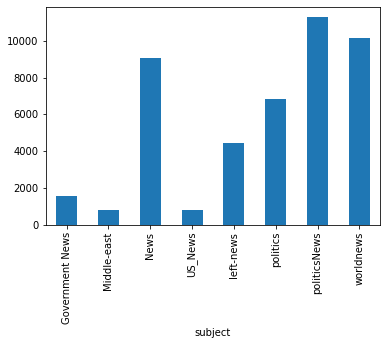

In [95]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind='bar')
plt.show()

target
fake    23481
real    21417
Name: text, dtype: int64


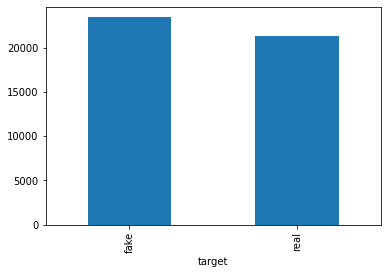

In [96]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind='bar')
plt.show()

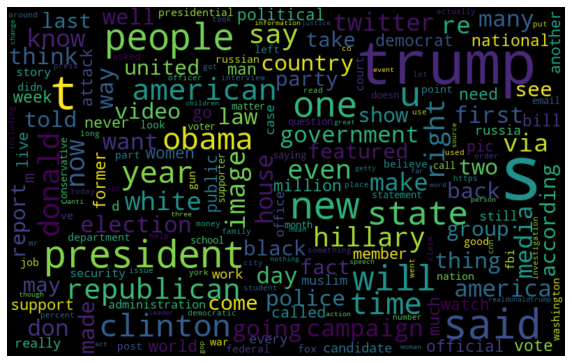

In [97]:
# Word Cloud for fake news
from wordcloud import WordCloud
fake_data = data[data['target'] == 'fake']
all_words = ' '.join([text for text in fake_data.text])

wordCloud = WordCloud(width = 800,
                      height=500,
                      max_font_size=110,
                      collocations=False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordCloud,interpolation='bilinear')
plt.axis('off')
plt.show()

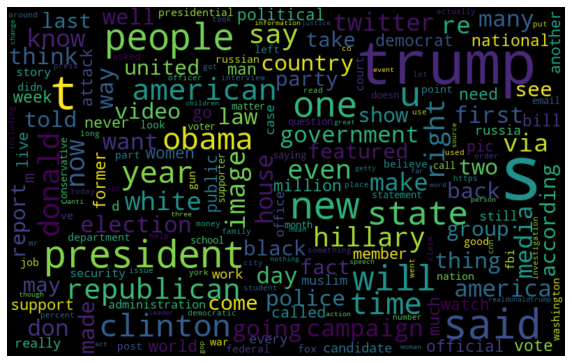

In [98]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data['target']=='true']
all_words=' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width=800, height=500,
                     max_font_size = 110,
                     collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordCloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [99]:
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

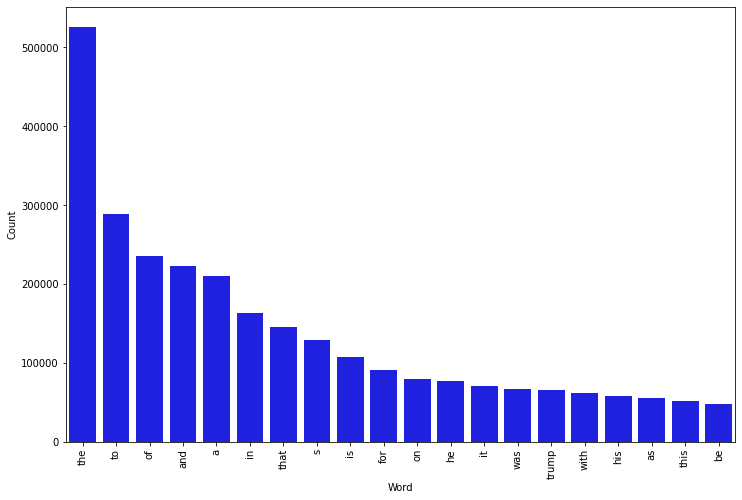

In [100]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

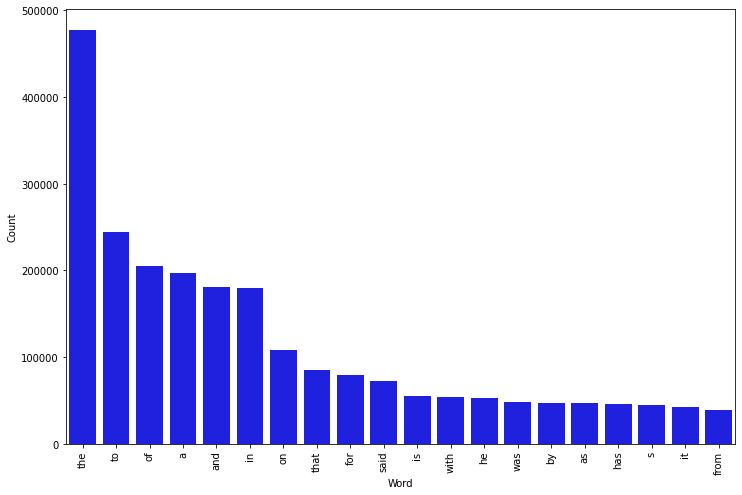

In [101]:
# Most frequent words in real news
counter(data[data["target"] == "real"], "text", 20)

# Modeling

In [102]:
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [103]:
data.to_csv('Tweets.csv')

# Preparing the data

In [104]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=20)


In [131]:
X_train

43673    a bernie sanders supporter who slammed hillary...
32959    washington/new york (reuters) - president dona...
13191     (in dec. 25 story, removes reference to shi i...
25778    following the tragic shooting of several polic...
9796      join patrick every wednesday at independent t...
                               ...                        
31962    washington (reuters) - the white house is set ...
23452    (reuters) - some influential u.s. senators are...
23775    you don t want to miss this!here s a little in...
37135    we know that the bp deepwater horizon oil spil...
27098    (reuters) - near the end of his eight years as...
Name: text, Length: 35918, dtype: object

# Logistic Regression

In [105]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
lr_model = pipe.fit(X_train, y_train)

# Accuracy
prediction = lr_model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.0%


Confusion matrix, without normalization


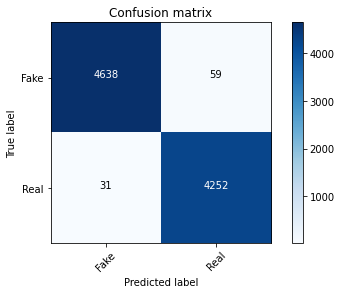

In [106]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])


# Multinomial Naive Bayes

In [107]:
from sklearn.naive_bayes import MultinomialNB
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

# Fitting the model
mnb_model = pipe.fit(X_train, y_train)

# Accuracy
prediction = mnb_model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))


accuracy: 93.72%


Confusion matrix, without normalization


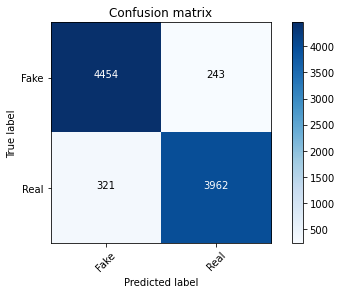

In [108]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])


# Decision Tree

In [109]:
from sklearn.tree import DecisionTreeClassifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])

# Fitting the model
dt_model = pipe.fit(X_train, y_train)

# Accuracy
prediction = dt_model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.67%


Confusion matrix, without normalization


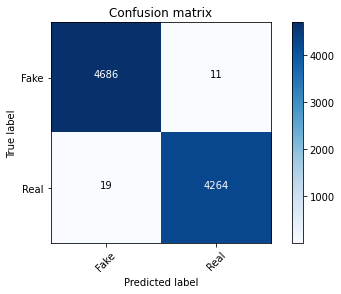

In [110]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])


# Random Forest classifier

In [111]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

rfc_model = pipe.fit(X_train, y_train)
prediction = rfc_model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.29%


Confusion matrix, without normalization


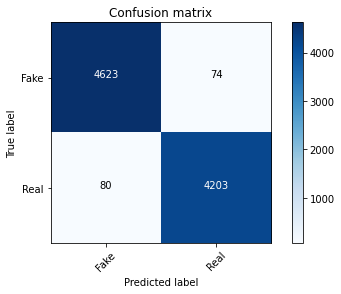

In [112]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])


# Linear Support Vector Machine

In [113]:
from sklearn.svm import LinearSVC

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC())])

svc_model = pipe.fit(X_train, y_train)
prediction = svc_model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.5%


Confusion matrix, without normalization


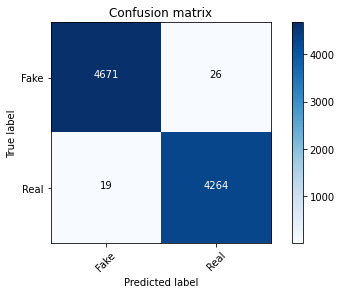

In [114]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Saving Model and Functions

In [115]:
import pickle

filename = 'cleaning_data.sav'
pickle.dump(create_features_from_df, open(filename, 'wb'))

filename = 'linear_reg.sav'
pickle.dump(lr_model, open(filename, 'wb'))

filename = 'svc_model.sav'
pickle.dump(svc_model, open(filename, 'wb'))

filename = 'rfc_model.sav'
pickle.dump(rfc_model, open(filename, 'wb'))

filename = 'dt_model.sav'
pickle.dump(dt_model, open(filename, 'wb'))

filename = 'mnb_model.sav'
pickle.dump(mnb_model, open(filename, 'wb'))

# Tweets Classification

In [116]:
# load 
svc_model = pickle.load(open("svc_model.sav", 'rb'))
dt_model = pickle.load(open("dt_model.sav", 'rb'))
mnb_model = pickle.load(open("mnb_model.sav", 'rb'))
rfc_model = pickle.load(open("rfc_model.sav", 'rb'))
lr_model = pickle.load(open("linear_reg.sav", 'rb'))
cleaning_data= pickle.load(open("cleaning_data.sav", 'rb'))

In [117]:
category_codes = {
    'Real': 'Real',
    'Fake': 'Fake'
}

In [118]:
# Tweets Scraping
import tweepy
def get_tweets(item):
    #Twitter API credentials
    consumer_key =  "2y5779N6k5EZpOz3VmOyabJHc"
    consumer_secret = "q4DR8al72steNMS8Uf4PMmAU9sR0OTWMEwbu2DGZU35S7jN1ff"
    access_token = "1534057526483832832-cHWlsx6qpL9XlXt5zCSbG1pIom6lom"
    access_token_secret = "Kj7bDn8dlvQEloRflgpAtLC1IgOoF9dkWFluRfux5MlzD"
    
    OAUTH_KEYS = {'consumer_key':consumer_key, 'consumer_secret':consumer_secret,
    'access_token_key':access_token, 'access_token_secret':access_token_secret}
    auth = tweepy.OAuthHandler(OAUTH_KEYS['consumer_key'], OAUTH_KEYS['consumer_secret'])
    api = tweepy.API(auth, wait_on_rate_limit=True)

    # Request
    search = tweepy.Cursor(api.search_tweets,q=item,lang='en').items(60)

    # Creation des listes pour chaque tweet
    sn = []
    text = []
    url=[]
    tweet_id = []
    timestamp =[]
    for tweet in search:
        sn.append(tweet.user.screen_name)
        text.append(tweet.text)
        url.append(f"https://twitter.com/user/status/{tweet.id}")
        tweet_id.append(tweet.id)
    # df_features
    df_features = pd.DataFrame(
        {'id':tweet_id,'tweets': text}
    )

    df_show_info = pd.DataFrame(
        {'User Screen Name': sn
        }
    )
    
    df_url = pd.DataFrame(
        {
            'id':tweet_id,
            'URL': url
        }
    )
    return (df_features,df_show_info,df_url)

In [119]:
def get_category_name(category_id):
    for category, id_ in category_codes.items():    
        if id_ == category_id:
            return category

In [120]:
def predict_from_features(features):
        
    predictions_pre = svc_model.predict(features)

    predictions = []

    for cat in predictions_pre:
           predictions.append(cat)

    categories = [get_category_name(x) for x in predictions]
    
    return categories

In [121]:
def complete_df(df, categories):
    df['Prediction'] = categories
    return df

In [122]:
search = input("Enter the item:")
(df_features,df_show_info,df_url) = get_tweets(search)

In [132]:
features = cleaning_data(df_features)
features.head()

# features.to_csv('Sports.csv')

,id,tweets,cleaned_tweets
0,1579499821878345728,RT @fightcomps_: Bro F’d around and found out ...,rt fightcomps bro f’d around and found out \n...
1,1579499820242595841,Why You Should Seriously Consider Switching to...,why you should seriously consider switching to...
2,1579499820112556034,"@nflrums I sure feel bad for him, must be roug...",nflrums i sure feel bad for him must be rough ...
3,1579499815775645697,#DFS Monday Night Football DraftKings Picks: N...,dfs monday night football draftkings picks nfl...
4,1579499814429286402,@ninaturner So the white students were paid? ...,ninaturner so the white students were paid su...


In [133]:
url = df_url

url.head()


,id,URL
0,1579499821878345728,https://twitter.com/user/status/15794998218783...
1,1579499820242595841,https://twitter.com/user/status/15794998202425...
2,1579499820112556034,https://twitter.com/user/status/15794998201125...
3,1579499815775645697,https://twitter.com/user/status/15794998157756...
4,1579499814429286402,https://twitter.com/user/status/15794998144292...


In [134]:
# features = pd.read_csv("Sports.csv")
# url = pd.read_csv("URLS.csv")

TotalData = pd.merge(features,url,on='id',how='left')[['tweets','URL']]

TotalData

TotalData.to_csv('Tweets_and_Id.csv')